## Import Librairies

In [14]:
import kagglehub
from __future__ import division
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from scipy import signal
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import numpy as np
import soundfile as sf
import xgboost
import pandas as pd
import numpy as np
import seaborn as sn
import os


## Import Data

In [9]:

# Download latest version
path = kagglehub.dataset_download("potamitis/wingbeats")

print("Path to dataset files:", path)

100%|██████████| 3.95G/3.95G [01:54<00:00, 36.9MB/s]

Extracting files...


Path to dataset files: /Users/timotheepiron/.cache/kagglehub/datasets/potamitis/wingbeats/versions/1


In [5]:
def get_data(target_names, max_files_per_class=15000, path=""):
    """
    Charge les données audio depuis une structure de fichiers complexe,
    avec une limite de fichiers par classe.
    """
    X = []                    # Données audio
    y = []                    # Labels des classes
    filenames = []            # Noms des fichiers
    target_count = []         # Comptage des fichiers par classe

    for i, target in enumerate(target_names):
        target_count.append(0)  # Initialiser le compteur par classe
        base_path = os.path.join(path, "Wingbeats", target)  # Chemin de base pour chaque classe
        print(f"Base path for {target}: {base_path}")

        for root, dirs, files in os.walk(base_path):  # Parcours récursif des sous-dossiers
            for filename in files:
                if filename.endswith('.wav'):  # Vérifie si c'est un fichier .wav
                    filepath = os.path.join(root, filename)  # Chemin complet du fichier
                    try:
                        data, fs = sf.read(filepath)  # Lecture du fichier audio
                        X.append(data)  # Ajout des données audio
                        y.append(i)  # Ajout du label
                        filenames.append(filepath)  # Sauvegarde du chemin du fichier
                        target_count[i] += 1  # Incrémentation du compteur

                        # Arrêtez après avoir chargé max_files_per_class fichiers
                        if target_count[i] >= max_files_per_class:
                            break
                    except Exception as e:
                        print(f"Error reading {filepath}: {e}")

            # Vérifie si la limite est atteinte pour cette classe
            if target_count[i] >= max_files_per_class:
                print(f"Limite atteinte pour {target}: {target_count[i]} fichiers")
                break

        print(f"{target} #recs = {target_count[i]}")  # Affiche le nombre d'enregistrements par classe

    if len(X) == 0:
        print("No data found! Check the dataset path and structure.")
        return None, None

    # Conversion des listes en tableaux NumPy
    X = np.vstack(X)
    y = np.hstack(y)

    X = X.astype("float32")  # Conversion des données en float32
    print("\nTotal dataset size:")
    print(f"# of classes: {len(np.unique(y))}")
    print(f"Total dataset size: {X.shape[0]}")
    print(f"Sampling frequency = {fs} Hz")
    print(f"n_samples: {X.shape[1]}")
    print(f"Duration (sec): {X.shape[1]/fs:.2f}")

    return X, y


In [8]:

# main
fs = 8000
target_names = ['Ae. aegypti', 'Ae. albopictus', 'An. gambiae', 'An. arabiensis', 'C. pipiens', 'C. quinquefasciatus']

X, y = get_data(target_names, path=path)

# Just to be sure
X, y = shuffle(X,y, random_state=2018)

names = ["XGBoost", "Random Forest", "ExtraTreesClassifier", "Linear SVM", "RBF SVM"]

classifiers = [
    XGBClassifier(n_estimators=650, learning_rate=0.2, use_label_encoder=False),
    RandomForestClassifier(n_estimators=650, min_samples_split=3, min_samples_leaf=2, random_state=2018, n_jobs=-1),
    ExtraTreesClassifier(n_estimators=650, random_state=2018, n_jobs=-1),
    SVC(kernel="linear", C=0.01),
    SVC(gamma=0.008, C=0.1),
]





Base path for Ae. aegypti: /Users/charlesdecommer/.cache/kagglehub/datasets/potamitis/wingbeats/versions/1/Wingbeats/Ae. aegypti
Limite atteinte pour Ae. aegypti: 15000 fichiers
Ae. aegypti #recs = 15000
Base path for Ae. albopictus: /Users/charlesdecommer/.cache/kagglehub/datasets/potamitis/wingbeats/versions/1/Wingbeats/Ae. albopictus
Limite atteinte pour Ae. albopictus: 15000 fichiers
Ae. albopictus #recs = 15000
Base path for An. gambiae: /Users/charlesdecommer/.cache/kagglehub/datasets/potamitis/wingbeats/versions/1/Wingbeats/An. gambiae
Limite atteinte pour An. gambiae: 15000 fichiers
An. gambiae #recs = 15000
Base path for An. arabiensis: /Users/charlesdecommer/.cache/kagglehub/datasets/potamitis/wingbeats/versions/1/Wingbeats/An. arabiensis
Limite atteinte pour An. arabiensis: 15000 fichiers
An. arabiensis #recs = 15000
Base path for C. pipiens: /Users/charlesdecommer/.cache/kagglehub/datasets/potamitis/wingbeats/versions/1/Wingbeats/C. pipiens
Limite atteinte pour C. pipiens: 

## Develop Model

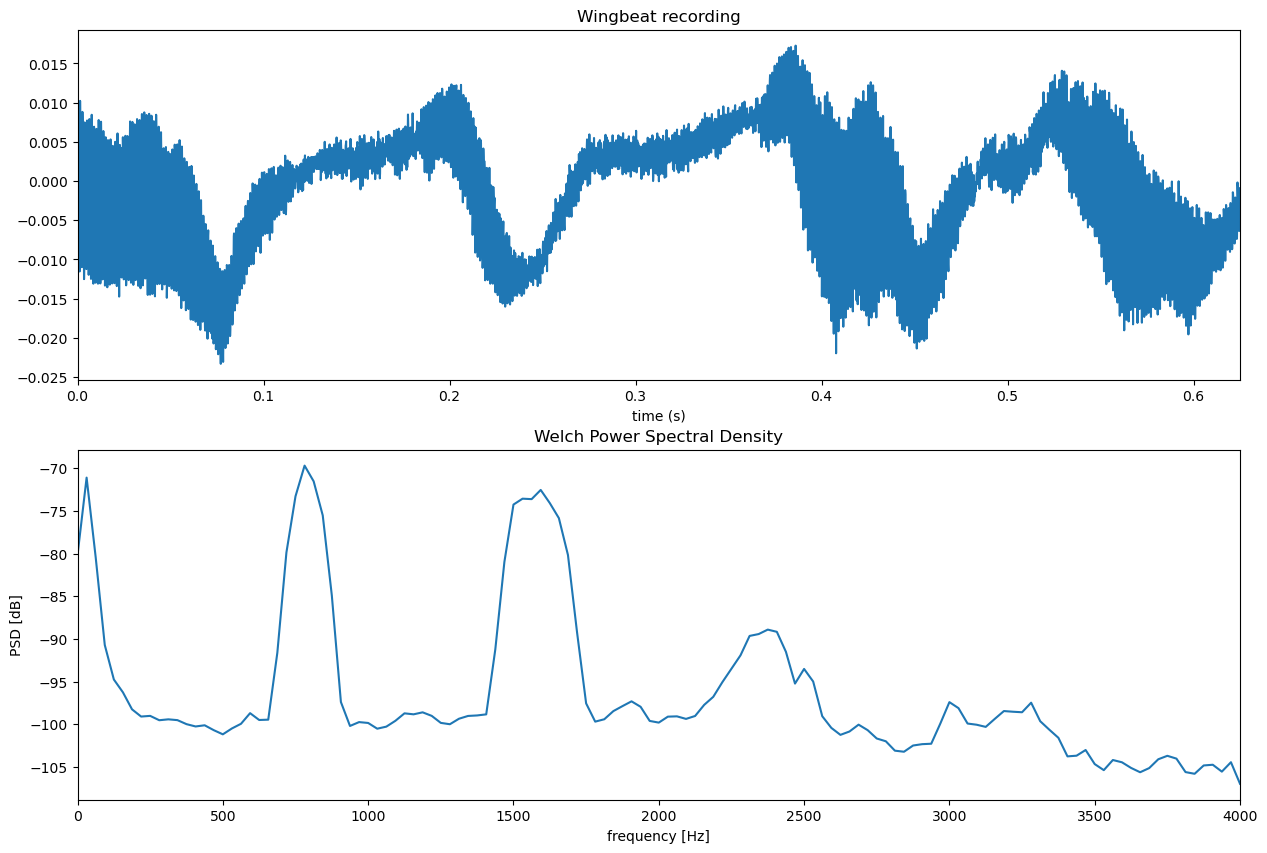

In [11]:
# transform the data
XX = np.zeros((X.shape[0],129)).astype("float32")   # allocate space
for i in range(X.shape[0]):
    XX[i] = 10*np.log10(signal.welch(X[i], fs=fs, window='hann', nperseg=256, noverlap=128+64)[1])

# Show one recording
plt.figure(figsize = (15,10))
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0,X.shape[1]/fs,X.shape[1]),X[0])
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('time (s)')
plt.title('Wingbeat recording')

plt.subplot(2, 1, 2)
plt.plot(np.linspace(0,fs/2,129),XX[0])
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Welch Power Spectral Density')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.20, random_state=2018)


Name: XGBoost, ac: 0.836667



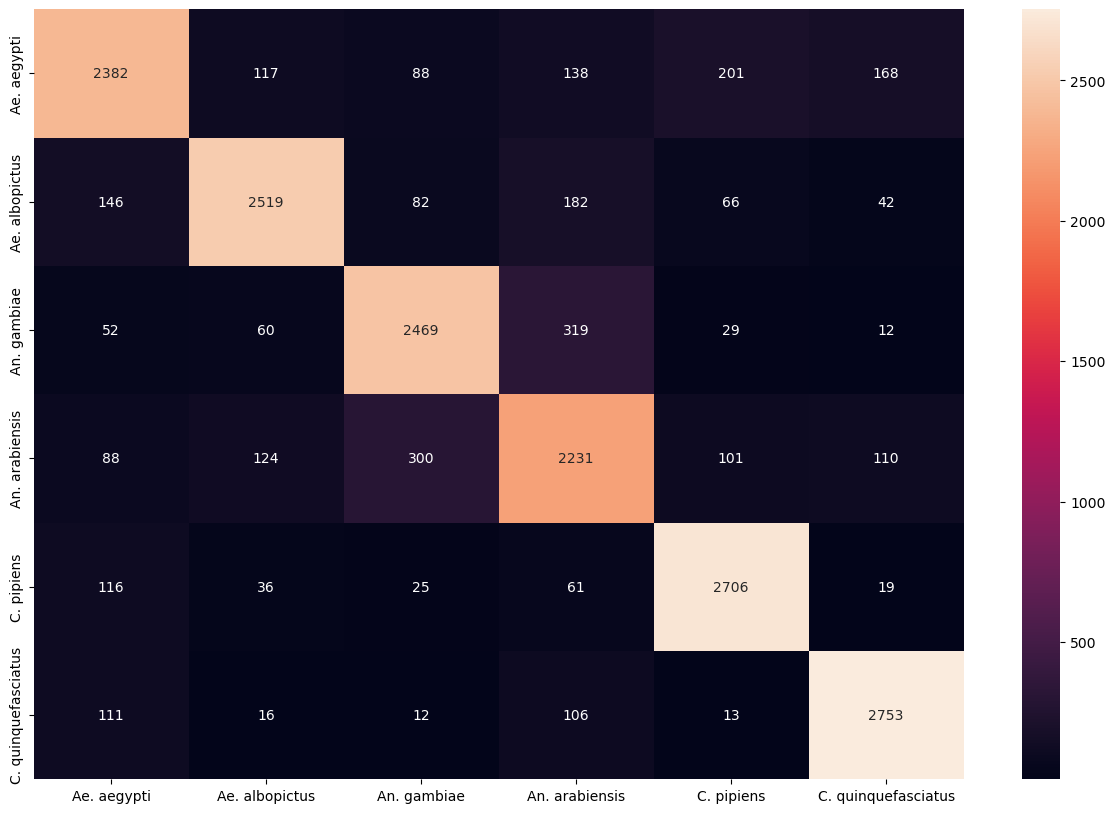

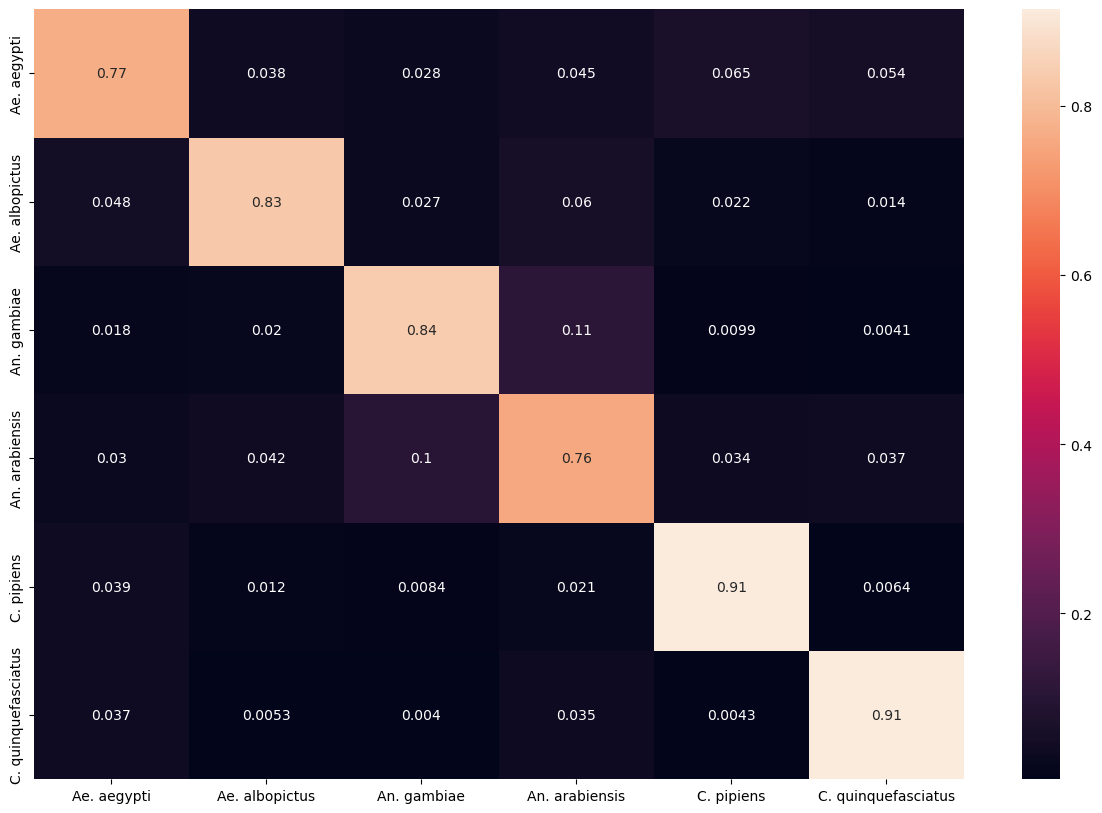

In [12]:


# fit model no training data
model = xgboost.XGBClassifier(n_estimators=650, learning_rate=0.2)
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('XGBoost', ac))

# Print the confusiona matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, columns=target_names, index=target_names)
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True, fmt="d")

print("")

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, columns=target_names, index=target_names)
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True)
plt.show()

print("")



## Save Model

In [16]:
model.save_model('wingbeats_recognition_model.h5')


/Users/charlesdecommer/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:05:50] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
